**13-05 1D CNN을 이용한 IMDB 리뷰 분류**

In [1]:
#데이터 로드 및 단어 토큰화

#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

nltk.download('punkt')

#데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/pytorch-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/IMDB%20Dataset.csv", filename="IMDB Dataset.csv")

df = pd.read_csv('IMDB Dataset.csv')
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: >

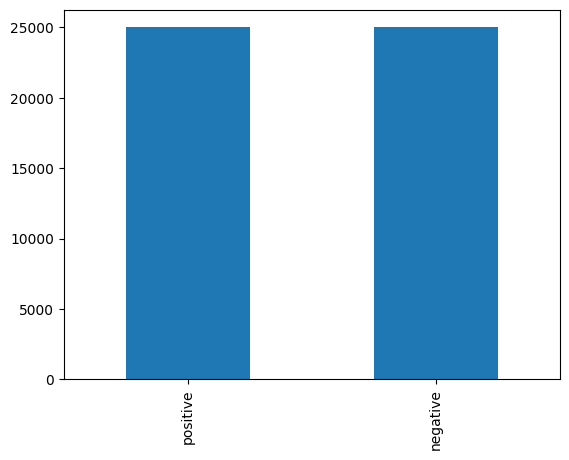

In [3]:
df['sentiment'].value_counts().plot(kind='bar')

In [4]:
#레이블 개수 확인
print('레이블 개수')
print(df.groupby('sentiment').size().reset_index(name='count'))

레이블 개수
  sentiment  count
0  negative  25000
1  positive  25000


In [5]:
#레이블 변환
df['sentiment'] = df['sentiment'].replace(['positive','negative'],[1,0])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
#데이터 정의
X_data = df['review']
y_data = df['sentiment']
print('X_data :', len(X_data))
print("y_data :", len(y_data))

X_data : 50000
y_data : 50000


In [7]:
#훈련 / 검증 / 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.5, random_state =0, stratify = y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=0, stratify= y_train)

print('------훈련 데이터의 비율-------')
print(f"부정 리뷰 = {round(y_train.value_counts()[0]/len(y_train)*100,3)}%")
print(f"긍정 리뷰 = {round(y_train.value_counts()[1]/len(y_train)*100,3)}%")
print('------검증 데이터의 비율-------')
print(f"부정 리뷰 = {round(y_valid.value_counts()[0]/len(y_valid)*100,3)}%")
print(f"긍정 리뷰 = {round(y_valid.value_counts()[1]/len(y_valid)*100,3)}%")
print('------테스트 데이터의 비율-------')
print(f"부정 리뷰 = {round(y_test.value_counts()[0]/len(y_test)*100,3)}%")
print(f"긍정 리뷰 = {round(y_test.value_counts()[1]/len(y_test)*100,3)}%")

------훈련 데이터의 비율-------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
------검증 데이터의 비율-------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
------테스트 데이터의 비율-------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%


In [8]:
#토큰화

#토큰화 함수 정의

def tokenize(sentences):
    tokenized_sentences = []
    for sent in tqdm(sentences):
        tokenized_sent = word_tokenize(sent)
        tokenized_sent = [word.lower() for word in tokenized_sent]
        tokenized_sentences.append(tokenized_sent)
    return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(X_test)

100%|██████████| 25000/25000 [00:41<00:00, 604.58it/s]


In [9]:
#Vocab 만들기

word_list = []
for sent in tokenized_X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 100586


In [10]:
#빈도수 낮은 데이터 배제
vocab = sorted(word_counts, key = word_counts.get, reverse=True)


#빈도수 3회 미만의 데이터
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold -1}번 이하인 희귀 단어의 수: {rare_cnt}')
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq)*100)

단어 집합의 크기 : 100586
등장 빈도가 2번 이하인 희귀 단어의 수: 61877
단어 집합에서 희귀 단어의 비율 : 61.51651323245779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.3294254426463437


In [11]:
# 빈도수 2 이하 단어 제거
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]

In [12]:
print(len(vocab))

38709


In [13]:
#정수 부여
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab):
    word_to_index[word] = index +2

vocab_size = len(word_to_index)
print('단어 집합의 크기', vocab_size)

단어 집합의 크기 38711


In [14]:
#정수 인코딩

#인코딩 함수
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)
    return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)

In [15]:
#패딩 길이 확인하기
#최대길이인 2818로 패딩하면 크기가 너무 크다

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence)<=max_len):
            count = count + 1
    print(f'전체 샘플중 길이가 {max_len} 이하인 샘플의 비율 : {(count / len(nested_list))*100}')


In [16]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플중 길이가 500 이하인 샘플의 비율 : 87.795


In [17]:
#길이 500으로 패딩

#패딩 함수 정의
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype = int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련데이터 :', padded_X_train.shape)
print('검증 데이터 :', padded_X_valid.shape)
print('테스트 데이터 :', padded_X_test.shape)

훈련데이터 : (20000, 500)
검증 데이터 : (5000, 500)
테스트 데이터 : (25000, 500)


In [18]:
#1D CNN모델링---------------

#import
import torch
import torch.nn as nn
import torch.nn.functional as F

#런타임 유형 확인
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
print('cpu와 cuda 중 다음 기기로 학습함 :', device)

cpu와 cuda 중 다음 기기로 학습함 : cuda


In [19]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([1, 1, 0, 0, 0])


In [20]:
#합성곱 신경망의 동작 과정
input = torch.randn(32, 16, 50)
m = nn.Conv1d(16, 33, 3, stride =1)
output = m(input)
print(output.shape)

torch.Size([32, 33, 48])


In [29]:
#CNN 모델을 클래스로 구현
class CNN(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(CNN, self).__init__()

        #오직 하나의 종류의 필터만 사용함
        self.num_filter_sizes = 1
        self.num_filters = 256

        self.word_embed = torch.nn.Embedding(num_embeddings = vocab_size, embedding_dim= 128, padding_idx = 0)

        self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias =True)

    def forward(self, inputs):
        embedded = self.word_embed(inputs).permute(0,2,1)

        x = F.relu(self.conv1(embedded).permute(0,2,1).max(1)[0])
        y_pred = self.fc1(self.dropout(x))

        return y_pred

In [30]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [31]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))


총 배치의 수 : 625


In [32]:
#모델 객체 선언
model = CNN(vocab_size, num_labels = len(set(y_train)))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [34]:
#평가코드 작성

def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


In [35]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


In [36]:
#학습
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 0.6536, Train Accuracy: 0.6412
Validation Loss: 0.5870, Validation Accuracy: 0.6610
Validation loss improved from inf to 0.5870. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.4991, Train Accuracy: 0.7550
Validation Loss: 0.3660, Validation Accuracy: 0.8442
Validation loss improved from 0.5870 to 0.3660. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.3994, Train Accuracy: 0.8234
Validation Loss: 0.3210, Validation Accuracy: 0.8564
Validation loss improved from 0.3660 to 0.3210. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.3009, Train Accuracy: 0.8720
Validation Loss: 0.3009, Validation Accuracy: 0.8748
Validation loss improved from 0.3210 to 0.3009. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.2169, Train Accuracy: 0.9115
Validation Loss: 0.3116, Validation Accuracy: 0.8722


In [37]:
#모델 로드 및 평가
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 0.3009
Best model validation accuracy: 0.8748


In [38]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')


Best model test loss: 0.3145
Best model test accuracy: 0.8653


In [39]:
#모델 테스트
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [40]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)


'부정'

In [41]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)


'긍정'